In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path

https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632

In [3]:
# annotation_file = Path("./birdclef-2022/train_metadata.csv")
annotation_file = Path("./train_folds.csv")

data_dir = Path("./birdclef-2022/spectograms_v2/")

dataframe = pd.read_csv(annotation_file)
dataframe.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,file_path,kfold
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg,birdclef-2022/train_audio/afrsil1/XC125458.ogg,0
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg,birdclef-2022/train_audio/afrsil1/XC175522.ogg,0
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg,birdclef-2022/train_audio/afrsil1/XC177993.ogg,1
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg,birdclef-2022/train_audio/afrsil1/XC205893.ogg,4
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg,birdclef-2022/train_audio/afrsil1/XC207431.ogg,4


## loading data

In [4]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, data_dir, transform=None, target_transform=None):
        self.labels = pd.read_csv(annotations_file)
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = data_dir / (self.labels.iloc[idx].filename[:-4] + ".npy")
        spect = np.load(img_path)
        label = self.labels.iloc[idx].primary_label
        if self.transform:
            spect = self.transform(spect)
            # spect.transpose_(0, 2).transpose_(0, 1)
        if self.target_transform:
            label = self.target_transform([label])
        return spect, label

In [5]:
class OneHotEncoder():
  def __init__(self, classes):
    self.num_classes = len(classes)
    self.classes = {}
    for i, c in enumerate(classes):
      self.classes[c] = i

  def transform(self, vals):
    xs = []
    for val in vals:
      x = np.zeros(self.num_classes)
      x[self.classes[val]] = 1
      xs.append(x)
    return xs

classes = list("abcd")
encoder = OneHotEncoder(classes)
encoder.transform("b")

[array([0., 1., 0., 0.])]

In [6]:
from sklearn.preprocessing import LabelEncoder

classes = dataframe.primary_label.unique()
le = LabelEncoder()
le.fit(classes)

dataset = CustomDataset(
    annotations_file = annotation_file,
    data_dir = data_dir,
    transform = transforms.ToTensor(),
    target_transform = le.transform
)

In [7]:
len(dataset) * 0.8, len(dataset)

(11881.6, 14852)

In [8]:
train_set, val_set = torch.utils.data.random_split(dataset, [11881, 2971], generator=torch.Generator().manual_seed(42))

batch_size = 16
train_dataloader = DataLoader(train_set, batch_size = batch_size)
val_dataloader = DataLoader(val_set, batch_size = batch_size)

Feature batch shape: torch.Size([16, 1, 224, 313])
Labels batch shape: 16


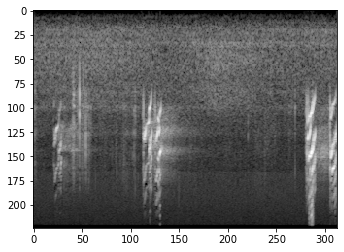

Label: tensor([123])


In [12]:
train_features, train_labels = next(iter(train_dataloader))
# train_features.squeeze_().swapaxes_(0, 1).swapaxes_(0, 2)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
idx = 2
img = train_features[idx].squeeze()
label = train_labels[idx]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Model architecture

In [13]:
import math
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)

        tmp = torch.cos(position * div_term)
        
        if (d_model % 2 == 0):
            pe[:, 0, 1::2] = tmp
        else:
            # FIXME make sure that it makes sense to delete last entry of array
            pe[:, 0, 1::2] = tmp[:, :-1]

        
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [24]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, n_classes: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        # self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, d_model)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        # self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        # src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

class Net(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, n_classes: int, dropout: float = 0.5):
        super().__init__()
        self.transformer = TransformerModel(ntoken =  ntoken,
                            d_model = d_model,
                            nhead = nhead,
                            d_hid = d_hid,
                            nlayers = nlayers,
                            n_classes = n_classes)#.to(device)
        self.global_average = nn.AvgPool2d((3, 3))
        self.fc1 = nn.Linear(7696, 512)
        self.fc2 = nn.Linear(512, n_classes)

    def forward(self, x: Tensor) -> Tensor:
        x = x.squeeze_().swapaxes_(0, 1).swapaxes_(0, 2)
        x = self.transformer(x)
        x = self.transformer(x)
        x = self.transformer(x)
        x.swapaxes_(0, 1)

        x = self.global_average(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x)


# preprocess a 5-second chunk
train_features, train_labels = next(iter(train_dataloader))
train_features.squeeze_()
print(f"Feature batch shape: {train_features.size()}")
ntoken = 313#train_features.size()[2]
d_model = train_features.size()[1]

n_classes = len(dataframe.primary_label.unique())
d_hid = 200 # dimension of the feed-forward network model in nn.TransformerEncoder
nlayers = 1 # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 1 # number of heads in nn.MultiheadAttention
dropout = 0.2 # dropout probability
print(f"ntoken {ntoken}, d_model {d_model}")
model = Net(ntoken =  ntoken,
                        d_model = d_model,
                        nhead = nhead,
                        d_hid = d_hid,
                        nlayers = nlayers,
                        n_classes = n_classes).to(device)
model

Feature batch shape: torch.Size([64, 224, 313])
ntoken 313, d_model 224


Net(
  (transformer): TransformerModel(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=224, out_features=224, bias=True)
          )
          (linear1): Linear(in_features=224, out_features=200, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=200, out_features=224, bias=True)
          (norm1): LayerNorm((224,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((224,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
      )
    )
    (decoder): Linear(in_features=224, out_features=224, bias=True)
  )
  (global_average): AvgPool2d(kernel_size=(3, 3), str

## ViT

In [38]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 1, patch_size: int = 9, emb_size: int = 224, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn(817, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x
    
x, _ = next(iter(train_dataloader))
PatchEmbedding()(x).shape

torch.Size([16, 817, 224])

In [236]:
class Time2Vec(nn.Module): # Positional Encoding layer
    
  def __init__(self, seq_len: int = 313):
    super().__init__()
    self.seq_len = seq_len
    
    bound = 1
        
    weights_linear = torch.Tensor(seq_len)
    self.weights_linear = nn.Parameter(weights_linear)
    nn.init.uniform_(self.weights_linear, -bound, bound)
    
    bias_linear = torch.Tensor(seq_len)
    self.bias_linear = nn.Parameter(bias_linear)
    nn.init.uniform_(self.bias_linear, -bound, bound)
    
    weights_periodic_1 = torch.Tensor(seq_len)
    self.weights_periodic_1 = nn.Parameter(weights_periodic_1)
    nn.init.uniform_(self.weights_periodic_1, -bound, bound)
    
    bias_periodic_1 = torch.Tensor(seq_len)
    self.bias_periodic_1 = nn.Parameter(bias_periodic_1)
    nn.init.uniform_(self.bias_periodic_1, -bound, bound)

    weights_periodic_2 = torch.Tensor(seq_len)
    self.weights_periodic_2 = nn.Parameter(weights_periodic_2)
    nn.init.uniform_(self.weights_periodic_2, -bound, bound)
    
    bias_periodic_2 = torch.Tensor(seq_len)
    self.bias_periodic_2 = nn.Parameter(bias_periodic_2)
    nn.init.uniform_(self.bias_periodic_2, -bound, bound)

    weights_periodic_3 = torch.Tensor(seq_len)
    self.weights_periodic_3 = nn.Parameter(weights_periodic_3)
    nn.init.uniform_(self.weights_periodic_3, -bound, bound)
    
    bias_periodic_3 = torch.Tensor(seq_len)
    self.bias_periodic_3 = nn.Parameter(bias_periodic_3)
    nn.init.uniform_(self.bias_periodic_3, -bound, bound)

  def forward(self, inputs): # where x has input shape (batch_size, channels, features, seq_len)
    x = torch.mean(inputs, dim = 2)
    x = x.squeeze()
    time_linear = self.weights_linear * x + self.bias_linear # (seq_len)
    time_periodic_1 = torch.sin(self.weights_periodic_1 * x + self.bias_periodic_1) # (seq_len)
    time_periodic_2 = torch.sin(self.weights_periodic_2 * x + self.bias_periodic_2) # (seq_len)
    time_periodic_3 = torch.sin(self.weights_periodic_3 * x + self.bias_periodic_3) # (seq_len)

    time_linear.unsqueeze_(1)
    time_periodic_1.unsqueeze_(1)
    time_periodic_2.unsqueeze_(1)
    time_periodic_3.unsqueeze_(1)

    out_time = torch.cat([time_linear, time_periodic_1, time_periodic_2, time_periodic_3], dim=1)
    out_time.unsqueeze_(1)
    out = torch.cat([inputs, out_time], dim = 2).squeeze().swapaxes(1, 2)
    return out # (batch_size, seq_len, features + 2)

x, _ = next(iter(train_dataloader))
layer = Time2Vec(seq_len = 313)
print(x.shape)
x = layer(x)
print(x.shape)

torch.Size([16, 1, 224, 313])
torch.Size([16, 313, 228])


In [240]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 224, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

x, _ = next(iter(train_dataloader))
# patches_embedded = PatchEmbedding()(x)
x_time = Time2Vec(seq_len = 313)(x)
MultiHeadAttention(emb_size = 228, num_heads = 12)(x_time).shape

torch.Size([16, 313, 228])

In [303]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 224,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 attention_drop_p: float = 0.,
                 num_heads: int = 8,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size,
                    dropout = attention_drop_p,
                    num_heads = num_heads,
                    **kwargs),
                nn.Dropout(drop_p)
            )),
            # ResidualAdd(nn.Sequential(
            #     nn.LayerNorm(emb_size),
            #     FeedForwardBlock(
            #         emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
            #     nn.Dropout(drop_p)
            # ))
            )

x, _ = next(iter(train_dataloader))
# patches_embedded = PatchEmbedding()(x)
x_time = Time2Vec(seq_len = 313)(x)
TransformerEncoderBlock(emb_size = 228, num_heads = 12)(x_time).shape

torch.Size([16, 313, 228])

In [304]:

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 224, n_classes: int = 152):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 1,
                patch_size: int = 9,
                emb_size: int = 224,
                img_size: int = 224,
                depth: int = 8,
                n_classes: int = 152,
                drop_p: float = 0.4,
                forward_expansion: int = 4,
                forward_drop_p: float = 0.4,
                attention_drop_p: float = 0.4,
                seq_len: int = 313,
                num_heads: int = 8,
                time_size: int = 4,
                **kwargs):
        super().__init__(
            # PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            Time2Vec(seq_len = seq_len),
            TransformerEncoder(depth,
                emb_size = emb_size + time_size,
                drop_p = drop_p,
                forward_expansion = forward_expansion,
                forward_drop_p = forward_drop_p,
                attention_drop_p = attention_drop_p,
                num_heads = num_heads,
                **kwargs),
            ClassificationHead((emb_size + time_size), n_classes)
        )


In [305]:
from torchsummary import summary

summary(ViT(emb_size = 224, num_heads = 12), (1, 224, 313), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Time2Vec-1             [-1, 313, 228]               0
         LayerNorm-2             [-1, 313, 228]             456
            Linear-3             [-1, 313, 684]         156,636
           Dropout-4         [-1, 12, 313, 313]               0
            Linear-5             [-1, 313, 228]          52,212
MultiHeadAttention-6             [-1, 313, 228]               0
           Dropout-7             [-1, 313, 228]               0
       ResidualAdd-8             [-1, 313, 228]               0
         LayerNorm-9             [-1, 313, 228]             456
           Linear-10             [-1, 313, 684]         156,636
          Dropout-11         [-1, 12, 313, 313]               0
           Linear-12             [-1, 313, 228]          52,212
MultiHeadAttention-13             [-1, 313, 228]               0
          Dropout-14             [-1, 

## CNN

In [107]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.global_average = nn.AvgPool2d((3, 3))
        self.fc1 = nn.Linear(6800, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.global_average(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

n_classes = len(dataframe.primary_label.unique())
model = CNN(n_classes).to(device)
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (global_average): AvgPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0)
  (fc1): Linear(in_features=6800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=152, bias=True)
)

## Training

In [333]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [334]:
def train_model(config):
    wandb.init(project="birdclef", config = config)

    model = ViT(in_channels = config["in_channels"],
                emb_size = config["emb_size"],
                depth = config["depth"],
                n_classes = config["n_classes"],
                drop_p = config["drop_p"],
                forward_expansion = config["forward_expansion"],
                forward_drop_p = config["forward_drop_p"],
                attention_drop_p = config["attention_drop_p"],
                seq_len = config["seq_len"],
                num_heads = config["num_heads"],
                time_size = config["time_size"]).to(device)

    wandb.watch(model, log_freq=100)

    optimizer = torch.optim.AdamW(model.parameters(), lr = config["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    losses = []
    val_losses = []
    losses_epoch = []
    val_losses_epoch = []

    lowest_val_los = None

    epochs = 10
    for epoch in range(epochs):

        running_loss = 0.0  
        running_loss_count = 0

        model.train()
        for inputs, labels in train_dataloader:
            if device.type == 'cuda':
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()

            losses.append(loss)

            running_loss += loss.item()
            running_loss_count += 1

        losses_avrg = running_loss / running_loss_count
        losses_epoch.append(losses_avrg)
        wandb.log({"loss": losses_avrg})

        # print(f'[{epoch + 1}] loss: {losses_avrg:.3f}')
        running_loss = 0.0
        running_loss_count = 0

        val_running_loss = 0.0
        val_running_loss_count = 0
        model.eval()     # Optional when not using Model Specific layer

        for inputs, labels in val_dataloader:
            if device.type == 'cuda':
                inputs, labels = inputs.cuda(), labels.cuda()

            with torch.no_grad():
                target = model(inputs)
                val_loss = criterion(target, labels.squeeze())
                val_losses.append(val_loss)

                val_running_loss += val_loss.item()
                val_running_loss_count += 1

        losses_avrg_val = val_running_loss / val_running_loss_count
        if lowest_val_los is None:
            lowest_val_los = losses_avrg_val
        else:
            if losses_avrg_val < lowest_val_los:
                lowest_val_los = losses_avrg_val

        val_losses_epoch.append(losses_avrg_val)
        wandb.log({"val_loss": losses_avrg_val})

        # print(f'[{epoch + 1}] val loss: {losses_avrg_val:.3f}')
        val_running_loss = 0.0
        val_running_loss_count = 0

    # print('Finished Training')

    return lowest_val_los

In [323]:
n_classes = len(dataframe.primary_label.unique())

# num head options are: 1, 2, 3, 4, 6, 12, 19, 38, 57, 76, 114, 228

in_channels = 1
emb_size = 224
time_size = 4
seq_len = 313

depth = 1 # n of transformer layers
drop_p = 0.5 # 
forward_expansion = 2 # how much increase emb in linear
forward_drop_p = 0.5
attention_drop_p = 0.5
num_heads = 12
lr = 0.001

config = {
  "n_classes": n_classes,
  "in_channels": in_channels,
  "emb_size": emb_size,
  "depth": depth,
  "drop_p": drop_p,
  "forward_expansion": forward_expansion,
  "forward_drop_p": forward_drop_p,
  "attention_drop_p": attention_drop_p,
  "seq_len": seq_len,
  "num_heads": num_heads,
  "time_size": time_size, 
  "do_feed_forward": False,
  "learning_rate": lr
}

In [324]:
%%wandb
train_model(config)

wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[1] loss: 3.739
[1] val loss: 3.338
[2] loss: 3.057
[2] val loss: 3.080
[3] loss: 2.730
[3] val loss: 2.974
[4] loss: 2.488
[4] val loss: 2.918
[5] loss: 2.290
[5] val loss: 2.898
[6] loss: 2.104
[6] val loss: 2.956
[7] loss: 1.940
[7] val loss: 3.036
[8] loss: 1.778
[8] val loss: 3.142
[9] loss: 1.620
[9] val loss: 3.271
[10] loss: 1.483
[10] val loss: 3.433


In [335]:
%%wandb

import optuna

def objective(trial):

    # fixed params
    n_classes = len(dataframe.primary_label.unique())
    in_channels = 1
    emb_size = 224
    time_size = 4
    seq_len = 313

    # test params
    depth = trial.suggest_int("depth", 1, 6) # n of transformer layers
    drop_p = trial.suggest_float("drop_p", 0, 0.9, step=0.05)
    forward_expansion = trial.suggest_int("forward_expansion", 1, 6) # how much increase emb in linear
    forward_drop_p = trial.suggest_float("forward_drop_p", 0, 0.9, step=0.05)
    attention_drop_p = trial.suggest_float("attention_drop_p", 0, 0.9, step=0.05)
    num_heads = trial.suggest_categorical("num_heads", [1, 2, 3, 4, 6, 12]) # num head options are: 1, 2, 3, 4, 6, 12, 19, 38, 57, 76, 114, 228
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2)

    config = {
    "n_classes": n_classes,
    "in_channels": in_channels,
    "emb_size": emb_size,
    "depth": depth,
    "drop_p": drop_p,
    "forward_expansion": forward_expansion,
    "forward_drop_p": forward_drop_p,
    "attention_drop_p": attention_drop_p,
    "seq_len": seq_len,
    "num_heads": num_heads,
    "time_size": time_size, 
    "do_feed_forward": False,
    "learning_rate": lr
    }

    val_loss = train_model(config)
    return val_loss

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2022-05-23 00:36:51,475] A new study created in memory with name: no-name-40f813c2-5b97-42cd-9aec-72d0c0f62c86


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 00:40:39,668] Trial 0 finished with value: 4.363938416204145 and parameters: {'depth': 6, 'drop_p': 0.9, 'forward_expansion': 2, 'forward_drop_p': 0.45, 'attention_drop_p': 0.5, 'num_heads': 1, 'learning_rate': 0.003038529553965816}. Best is trial 0 with value: 4.363938416204145.


loss,█▃▃▂▂▁▁▁▃▃
val_loss,▁▁▂▃▄▇█▃▂▂
loss,4.30441
val_loss,4.38723


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 00:43:27,544] Trial 1 finished with value: 4.317554809713877 and parameters: {'depth': 3, 'drop_p': 0.0, 'forward_expansion': 2, 'forward_drop_p': 0.8, 'attention_drop_p': 0.35000000000000003, 'num_heads': 1, 'learning_rate': 0.007760944276204767}. Best is trial 1 with value: 4.317554809713877.


loss,█▁▂▄▆▅▄▂▁▄
val_loss,█▇▇▂▃▂▄▇▃▁
loss,4.24245
val_loss,4.31755


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 00:46:51,518] Trial 2 finished with value: 4.358227022232548 and parameters: {'depth': 5, 'drop_p': 0.75, 'forward_expansion': 6, 'forward_drop_p': 0.4, 'attention_drop_p': 0.30000000000000004, 'num_heads': 1, 'learning_rate': 0.008316735931124558}. Best is trial 1 with value: 4.317554809713877.


loss,█▃▃▃▃▃▂▃▁▁
val_loss,█▃▆▇▂▂▂▂▂▁
loss,4.30132
val_loss,4.35823


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 00:51:26,816] Trial 3 finished with value: 3.223672822598488 and parameters: {'depth': 6, 'drop_p': 0.75, 'forward_expansion': 1, 'forward_drop_p': 0.5, 'attention_drop_p': 0.35000000000000003, 'num_heads': 4, 'learning_rate': 0.0004922888126979012}. Best is trial 3 with value: 3.223672822598488.


loss,█▄▃▂▁▁▁▁▁▁
val_loss,▆▃▃▃▁▁▂▅▅█
loss,2.89913
val_loss,3.60025


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 00:54:01,013] Trial 4 finished with value: 4.207160870234172 and parameters: {'depth': 3, 'drop_p': 0.30000000000000004, 'forward_expansion': 4, 'forward_drop_p': 0.1, 'attention_drop_p': 0.55, 'num_heads': 1, 'learning_rate': 0.0049651943203634415}. Best is trial 3 with value: 3.223672822598488.


loss,█▄▂▂▁▂▄▅▃▂
val_loss,█▅▅▁▄▂▃▃▄█
loss,3.96382
val_loss,4.86788


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 00:57:13,841] Trial 5 finished with value: 3.819842794890045 and parameters: {'depth': 4, 'drop_p': 0.0, 'forward_expansion': 3, 'forward_drop_p': 0.05, 'attention_drop_p': 0.0, 'num_heads': 3, 'learning_rate': 0.002992515686443774}. Best is trial 3 with value: 3.223672822598488.


loss,█▄▂▄▄▄▂▂▁▁
val_loss,▂█▁▅▇█▅▄▃▅
loss,3.82244
val_loss,3.90453


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 00:59:27,590] Trial 6 finished with value: 3.994885233140761 and parameters: {'depth': 2, 'drop_p': 0.45, 'forward_expansion': 6, 'forward_drop_p': 0.65, 'attention_drop_p': 0.75, 'num_heads': 1, 'learning_rate': 0.0014934251702255045}. Best is trial 3 with value: 3.223672822598488.


loss,█▅▃▃▂▂▂▂▁▁
val_loss,▂▁▄▆█▆▆▆██
loss,3.231
val_loss,4.48186


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:01:44,456] Trial 7 finished with value: 3.0504493142968867 and parameters: {'depth': 2, 'drop_p': 0.4, 'forward_expansion': 5, 'forward_drop_p': 0.5, 'attention_drop_p': 0.30000000000000004, 'num_heads': 2, 'learning_rate': 0.0009717431945566722}. Best is trial 7 with value: 3.0504493142968867.


loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▇▅▄▃▂▂▁▁▁
loss,2.70838
val_loss,3.05045


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:04:41,450] Trial 8 finished with value: 4.336734516646272 and parameters: {'depth': 4, 'drop_p': 0.8, 'forward_expansion': 6, 'forward_drop_p': 0.7000000000000001, 'attention_drop_p': 0.9, 'num_heads': 1, 'learning_rate': 0.0018602961787574884}. Best is trial 7 with value: 3.0504493142968867.


loss,█▃▅▅▄▅▅▄▂▁
val_loss,▂▁▄▃▃▄█▇▇▆
loss,3.99006
val_loss,5.07442


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:07:09,752] Trial 9 finished with value: 3.4370836352789276 and parameters: {'depth': 2, 'drop_p': 0.7000000000000001, 'forward_expansion': 2, 'forward_drop_p': 0.5, 'attention_drop_p': 0.0, 'num_heads': 4, 'learning_rate': 0.007479096808126231}. Best is trial 7 with value: 3.0504493142968867.


loss,█▅▄▄▃▂▂▂▁▁
val_loss,█▆▄▃▃▂▂▂▂▁
loss,3.12123
val_loss,3.43708


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:09:05,795] Trial 10 finished with value: 3.3091163635253906 and parameters: {'depth': 1, 'drop_p': 0.30000000000000004, 'forward_expansion': 4, 'forward_drop_p': 0.25, 'attention_drop_p': 0.15000000000000002, 'num_heads': 2, 'learning_rate': 0.005202292125446934}. Best is trial 7 with value: 3.0504493142968867.


loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▅▄▃▂▂▂▂▁▁
loss,2.99478
val_loss,3.30912


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:16:14,516] Trial 11 finished with value: 2.634212694501364 and parameters: {'depth': 6, 'drop_p': 0.55, 'forward_expansion': 5, 'forward_drop_p': 0.55, 'attention_drop_p': 0.2, 'num_heads': 12, 'learning_rate': 0.00044640851626565775}. Best is trial 11 with value: 2.634212694501364.


loss,█▅▄▄▃▃▂▂▁▁
val_loss,█▃▂▁▁▁▁▂▂▂
loss,1.61241
val_loss,2.75504


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:18:40,925] Trial 12 finished with value: 3.0290551736790645 and parameters: {'depth': 1, 'drop_p': 0.5, 'forward_expansion': 5, 'forward_drop_p': 0.9, 'attention_drop_p': 0.2, 'num_heads': 12, 'learning_rate': 8.118289136711256e-05}. Best is trial 11 with value: 2.634212694501364.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▆▅▄▃▂▂▂▁▁
loss,2.69628
val_loss,3.02906


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:21:08,700] Trial 13 finished with value: 2.8663767742854294 and parameters: {'depth': 1, 'drop_p': 0.5, 'forward_expansion': 5, 'forward_drop_p': 0.9, 'attention_drop_p': 0.1, 'num_heads': 12, 'learning_rate': 0.00034499205535127946}. Best is trial 11 with value: 2.634212694501364.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▄▂▁▁▁▁▂▂▃
loss,1.68046
val_loss,3.02751


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:27:21,517] Trial 14 finished with value: 3.248757170733585 and parameters: {'depth': 5, 'drop_p': 0.6000000000000001, 'forward_expansion': 5, 'forward_drop_p': 0.9, 'attention_drop_p': 0.15000000000000002, 'num_heads': 12, 'learning_rate': 0.0031986786799677175}. Best is trial 11 with value: 2.634212694501364.


loss,█▅▃▂▂▂▂▁▁▁
val_loss,█▄▂▁▁▁▂▁▁▁
loss,2.87737
val_loss,3.25377


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:31:39,623] Trial 15 finished with value: 3.756012434600502 and parameters: {'depth': 5, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.65, 'attention_drop_p': 0.0, 'num_heads': 6, 'learning_rate': 0.009773437808674724}. Best is trial 11 with value: 2.634212694501364.


loss,█▅▄▃▁▁▁▂▁▁
val_loss,█▆▃▃▂▂▁▂▄▂
loss,3.73998
val_loss,3.8224


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:38:49,334] Trial 16 finished with value: 3.548656672559759 and parameters: {'depth': 6, 'drop_p': 0.6000000000000001, 'forward_expansion': 4, 'forward_drop_p': 0.30000000000000004, 'attention_drop_p': 0.15000000000000002, 'num_heads': 12, 'learning_rate': 0.004693040022074465}. Best is trial 11 with value: 2.634212694501364.


loss,█▃▂▂▂▂▁▁▃▅
val_loss,▃▁▁▁▃▄▂▃██
loss,3.74499
val_loss,4.05633


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:41:17,827] Trial 17 finished with value: 3.2410232892600437 and parameters: {'depth': 1, 'drop_p': 0.55, 'forward_expansion': 3, 'forward_drop_p': 0.8, 'attention_drop_p': 0.05, 'num_heads': 12, 'learning_rate': 5.2078709957107316e-05}. Best is trial 11 with value: 2.634212694501364.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▇▅▄▃▃▂▂▁▁
loss,3.01208
val_loss,3.24102


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:46:35,660] Trial 18 finished with value: 3.8168465834791943 and parameters: {'depth': 4, 'drop_p': 0.35000000000000003, 'forward_expansion': 5, 'forward_drop_p': 0.2, 'attention_drop_p': 0.65, 'num_heads': 12, 'learning_rate': 0.002166018293574656}. Best is trial 11 with value: 2.634212694501364.


loss,█▃▃▃▄▃▃▂▂▁
val_loss,▂▁▃▆▅█▆▄▅▃
loss,3.63942
val_loss,3.92133


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:50:55,424] Trial 19 finished with value: 3.430432892614795 and parameters: {'depth': 3, 'drop_p': 0.15000000000000002, 'forward_expansion': 6, 'forward_drop_p': 0.75, 'attention_drop_p': 0.25, 'num_heads': 12, 'learning_rate': 0.00616997417306706}. Best is trial 11 with value: 2.634212694501364.


loss,█▅▅▄▄▃▂▂▁▁
val_loss,▇█▇█▆▄▃▂▂▁
loss,3.3069
val_loss,3.43043


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:53:20,934] Trial 20 finished with value: 3.673786804240237 and parameters: {'depth': 2, 'drop_p': 0.65, 'forward_expansion': 4, 'forward_drop_p': 0.9, 'attention_drop_p': 0.4, 'num_heads': 3, 'learning_rate': 0.0037545873777297565}. Best is trial 11 with value: 2.634212694501364.


loss,█▅▄▄▄▃▂▁▁▁
val_loss,▄▁█▅█▃▁▃▂▁
loss,3.36794
val_loss,3.69382


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:55:47,490] Trial 21 finished with value: 2.8575086221900037 and parameters: {'depth': 1, 'drop_p': 0.5, 'forward_expansion': 5, 'forward_drop_p': 0.9, 'attention_drop_p': 0.2, 'num_heads': 12, 'learning_rate': 0.00020077495473140355}. Best is trial 11 with value: 2.634212694501364.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▅▃▂▂▁▁▁▁▁
loss,2.02085
val_loss,2.86624


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 01:58:16,112] Trial 22 finished with value: 3.8716232686914425 and parameters: {'depth': 1, 'drop_p': 0.45, 'forward_expansion': 5, 'forward_drop_p': 0.6000000000000001, 'attention_drop_p': 0.1, 'num_heads': 12, 'learning_rate': 1.5081072422267226e-05}. Best is trial 11 with value: 2.634212694501364.


loss,█▅▄▄▃▃▂▂▁▁
val_loss,█▆▅▄▄▃▂▂▁▁
loss,3.83081
val_loss,3.87162


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:00:44,034] Trial 23 finished with value: 2.947355208858367 and parameters: {'depth': 1, 'drop_p': 0.55, 'forward_expansion': 6, 'forward_drop_p': 0.8500000000000001, 'attention_drop_p': 0.25, 'num_heads': 12, 'learning_rate': 0.0010473739624577436}. Best is trial 11 with value: 2.634212694501364.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,▆▂▁▁▁▂▃▅▆█
loss,1.4215
val_loss,3.53642


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:03:29,368] Trial 24 finished with value: 3.074851797473046 and parameters: {'depth': 2, 'drop_p': 0.5, 'forward_expansion': 5, 'forward_drop_p': 0.6000000000000001, 'attention_drop_p': 0.1, 'num_heads': 6, 'learning_rate': 0.00235091456901145}. Best is trial 11 with value: 2.634212694501364.


loss,█▆▄▃▃▂▂▂▁▁
val_loss,█▆▅▄▂▂▂▁▁▁
loss,2.68992
val_loss,3.07485


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:05:59,134] Trial 25 finished with value: 2.9643444566316504 and parameters: {'depth': 1, 'drop_p': 0.65, 'forward_expansion': 4, 'forward_drop_p': 0.75, 'attention_drop_p': 0.2, 'num_heads': 12, 'learning_rate': 0.0011568632016819176}. Best is trial 11 with value: 2.634212694501364.


loss,█▆▅▄▄▃▂▂▁▁
val_loss,▅▂▁▁▁▂▃▄▆█
loss,1.44124
val_loss,3.52328


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:09:21,164] Trial 26 finished with value: 2.662461374395637 and parameters: {'depth': 2, 'drop_p': 0.4, 'forward_expansion': 3, 'forward_drop_p': 0.8500000000000001, 'attention_drop_p': 0.45, 'num_heads': 12, 'learning_rate': 0.00045063883523954734}. Best is trial 11 with value: 2.634212694501364.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▄▂▁▁▁▁▂▂▃
loss,1.46546
val_loss,2.86097


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:13:39,938] Trial 27 finished with value: 2.6025100927199087 and parameters: {'depth': 3, 'drop_p': 0.2, 'forward_expansion': 3, 'forward_drop_p': 0.35000000000000003, 'attention_drop_p': 0.45, 'num_heads': 12, 'learning_rate': 0.0005938193952660172}. Best is trial 27 with value: 2.6025100927199087.


loss,█▅▄▄▃▃▂▂▁▁
val_loss,█▄▃▂▂▁▁▁▁▂
loss,1.73534
val_loss,2.72297


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:17:59,777] Trial 28 finished with value: 3.70606444856172 and parameters: {'depth': 3, 'drop_p': 0.15000000000000002, 'forward_expansion': 3, 'forward_drop_p': 0.35000000000000003, 'attention_drop_p': 0.6000000000000001, 'num_heads': 12, 'learning_rate': 0.002274841134107673}. Best is trial 27 with value: 2.6025100927199087.


loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▅▁▃▂▁▂▇█▆
loss,3.28377
val_loss,3.86164


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:20:51,107] Trial 29 finished with value: 3.985542307617844 and parameters: {'depth': 3, 'drop_p': 0.2, 'forward_expansion': 1, 'forward_drop_p': 0.2, 'attention_drop_p': 0.45, 'num_heads': 3, 'learning_rate': 0.003952401263855704}. Best is trial 27 with value: 2.6025100927199087.


loss,█▅▅▄▅▃▂▂▁▁
val_loss,▅█▇▇▄▂▂▁▁▂
loss,3.86506
val_loss,4.04192


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:24:50,242] Trial 30 finished with value: 3.3857579385080645 and parameters: {'depth': 4, 'drop_p': 0.1, 'forward_expansion': 2, 'forward_drop_p': 0.4, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.0008028349421533155}. Best is trial 27 with value: 2.6025100927199087.


loss,█▄▃▂▂▂▂▁▁▁
val_loss,▆▁▃█▆▁▇▅▂▂
loss,3.24558
val_loss,3.39611


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:28:11,812] Trial 31 finished with value: 2.970043429764368 and parameters: {'depth': 2, 'drop_p': 0.35000000000000003, 'forward_expansion': 3, 'forward_drop_p': 0.45, 'attention_drop_p': 0.45, 'num_heads': 12, 'learning_rate': 0.001560345340817716}. Best is trial 27 with value: 2.6025100927199087.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▄▃▂▂▁▁▂▂▂
loss,2.24709
val_loss,3.0494


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:31:33,575] Trial 32 finished with value: 2.837125575670632 and parameters: {'depth': 2, 'drop_p': 0.4, 'forward_expansion': 3, 'forward_drop_p': 0.30000000000000004, 'attention_drop_p': 0.4, 'num_heads': 12, 'learning_rate': 6.767707180414448e-05}. Best is trial 27 with value: 2.6025100927199087.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▆▅▄▃▂▂▂▁▁
loss,2.52904
val_loss,2.83713


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:35:55,720] Trial 33 finished with value: 2.65108226127522 and parameters: {'depth': 3, 'drop_p': 0.25, 'forward_expansion': 3, 'forward_drop_p': 0.30000000000000004, 'attention_drop_p': 0.4, 'num_heads': 12, 'learning_rate': 0.0008063585110373298}. Best is trial 27 with value: 2.6025100927199087.


loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▅▄▃▂▂▂▂▁▁
loss,2.2049
val_loss,2.65108


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:38:55,995] Trial 34 finished with value: 3.3292164661551036 and parameters: {'depth': 3, 'drop_p': 0.25, 'forward_expansion': 2, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.7000000000000001, 'num_heads': 4, 'learning_rate': 0.0007290901344779005}. Best is trial 27 with value: 2.6025100927199087.


loss,█▄▃▂▂▁▁▁▁▁
val_loss,▅▂▁▅▅▆▅▅▇█
loss,2.87193
val_loss,3.57087


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:41:37,191] Trial 35 finished with value: 4.277536430666523 and parameters: {'depth': 3, 'drop_p': 0.05, 'forward_expansion': 3, 'forward_drop_p': 0.35000000000000003, 'attention_drop_p': 0.55, 'num_heads': 2, 'learning_rate': 0.002963920178513036}. Best is trial 27 with value: 2.6025100927199087.


loss,█▆▅▅▄▃▂▂▁▁
val_loss,▂▁▂▁▆▄▄▆▄█
loss,3.7926
val_loss,4.99593


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:47:50,852] Trial 36 finished with value: 3.641885898446524 and parameters: {'depth': 5, 'drop_p': 0.25, 'forward_expansion': 3, 'forward_drop_p': 0.4, 'attention_drop_p': 0.35000000000000003, 'num_heads': 12, 'learning_rate': 0.0016030271306900672}. Best is trial 27 with value: 2.6025100927199087.


loss,█▄▃▂▂▂▁▂▁▁
val_loss,▄▂▅▃▁▄▃█▆█
loss,3.48342
val_loss,3.88948


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:52:11,372] Trial 37 finished with value: 3.579082973541752 and parameters: {'depth': 3, 'drop_p': 0.30000000000000004, 'forward_expansion': 2, 'forward_drop_p': 0.25, 'attention_drop_p': 0.5, 'num_heads': 12, 'learning_rate': 0.0026379018647225455}. Best is trial 27 with value: 2.6025100927199087.


loss,█▅▄▄▃▃▂▂▁▁
val_loss,▇▅▄▄▅█▂▃▃▁
loss,3.18416
val_loss,3.57908


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:55:43,726] Trial 38 finished with value: 3.8150267895831855 and parameters: {'depth': 4, 'drop_p': 0.4, 'forward_expansion': 1, 'forward_drop_p': 0.55, 'attention_drop_p': 0.4, 'num_heads': 4, 'learning_rate': 0.00124124864592286}. Best is trial 27 with value: 2.6025100927199087.


loss,█▃▄▅▂▁▁▁▂▁
val_loss,▂▁▄▇▅▃▄▅█▅
loss,3.69169
val_loss,4.02948


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 02:59:04,509] Trial 39 finished with value: 2.680586982798833 and parameters: {'depth': 2, 'drop_p': 0.05, 'forward_expansion': 4, 'forward_drop_p': 0.0, 'attention_drop_p': 0.35000000000000003, 'num_heads': 12, 'learning_rate': 0.0007107385076346916}. Best is trial 27 with value: 2.6025100927199087.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▄▂▂▁▁▂▂▃▄
loss,1.42769
val_loss,2.94379


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:02:46,106] Trial 40 finished with value: 4.397659879858776 and parameters: {'depth': 6, 'drop_p': 0.35000000000000003, 'forward_expansion': 2, 'forward_drop_p': 0.45, 'attention_drop_p': 0.30000000000000004, 'num_heads': 1, 'learning_rate': 0.0016905048838564895}. Best is trial 27 with value: 2.6025100927199087.


loss,█▆▅▄▄▂▂▁▃▁
val_loss,▃▁▁▂▂▃█▇▇▅
loss,4.1237
val_loss,4.68717


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:06:07,704] Trial 41 finished with value: 2.641489588445233 and parameters: {'depth': 2, 'drop_p': 0.0, 'forward_expansion': 4, 'forward_drop_p': 0.0, 'attention_drop_p': 0.35000000000000003, 'num_heads': 12, 'learning_rate': 0.00048726004708188943}. Best is trial 27 with value: 2.6025100927199087.


loss,█▆▅▄▄▃▂▂▁▁
val_loss,█▄▂▁▁▁▂▃▄▆
loss,1.04497
val_loss,3.06859


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:09:27,433] Trial 42 finished with value: 2.648798792592941 and parameters: {'depth': 2, 'drop_p': 0.0, 'forward_expansion': 3, 'forward_drop_p': 0.05, 'attention_drop_p': 0.55, 'num_heads': 12, 'learning_rate': 0.0006615161966768417}. Best is trial 27 with value: 2.6025100927199087.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▄▃▂▁▁▁▂▂▃
loss,1.50526
val_loss,2.83084


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:13:45,808] Trial 43 finished with value: 2.6009228280795518 and parameters: {'depth': 3, 'drop_p': 0.0, 'forward_expansion': 4, 'forward_drop_p': 0.0, 'attention_drop_p': 0.55, 'num_heads': 12, 'learning_rate': 0.0006038586861866863}. Best is trial 43 with value: 2.6009228280795518.


loss,█▅▄▄▃▃▂▂▁▁
val_loss,█▅▃▂▁▁▁▁▁▁
loss,1.76846
val_loss,2.60112


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:18:05,392] Trial 44 finished with value: 3.59796057977984 and parameters: {'depth': 3, 'drop_p': 0.0, 'forward_expansion': 4, 'forward_drop_p': 0.0, 'attention_drop_p': 0.55, 'num_heads': 12, 'learning_rate': 0.001839709100301383}. Best is trial 43 with value: 2.6009228280795518.


loss,█▅▃▃▃▂▁▁▁▁
val_loss,█▁▃▂▁▃▇█▆▆
loss,3.28242
val_loss,3.70331


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:20:24,685] Trial 45 finished with value: 3.726002138148072 and parameters: {'depth': 2, 'drop_p': 0.05, 'forward_expansion': 4, 'forward_drop_p': 0.05, 'attention_drop_p': 0.8, 'num_heads': 2, 'learning_rate': 0.0012991437204195656}. Best is trial 43 with value: 2.6009228280795518.


loss,█▅▄▃▃▂▂▁▁▁
val_loss,▁▁▁▃▄▄▅█▅▄
loss,2.98819
val_loss,4.29925


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:23:42,691] Trial 46 finished with value: 3.1238611757114367 and parameters: {'depth': 4, 'drop_p': 0.0, 'forward_expansion': 4, 'forward_drop_p': 0.1, 'attention_drop_p': 0.6000000000000001, 'num_heads': 3, 'learning_rate': 0.0004494437472397169}. Best is trial 43 with value: 2.6009228280795518.


loss,█▄▃▃▂▁▁▁▁▁
val_loss,█▄▄▃▁▁▂▅▅▄
loss,2.85281
val_loss,3.27245


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:27:04,853] Trial 47 finished with value: 3.2597909973513697 and parameters: {'depth': 2, 'drop_p': 0.9, 'forward_expansion': 4, 'forward_drop_p': 0.05, 'attention_drop_p': 0.5, 'num_heads': 12, 'learning_rate': 0.0021094046577813204}. Best is trial 43 with value: 2.6009228280795518.


loss,█▅▄▃▃▂▂▂▁▁
val_loss,▃▁▁▁▃▃▄▅▇█
loss,2.09396
val_loss,4.06045


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:31:25,064] Trial 48 finished with value: 4.040264278329829 and parameters: {'depth': 3, 'drop_p': 0.1, 'forward_expansion': 4, 'forward_drop_p': 0.1, 'attention_drop_p': 0.6000000000000001, 'num_heads': 12, 'learning_rate': 0.00944978893251491}. Best is trial 43 with value: 2.6009228280795518.


loss,█▅▃▂▃▂▁▂▁▂
val_loss,█▆▂▆▄▃▁▄▂▂
loss,4.02716
val_loss,4.06486


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:33:38,674] Trial 49 finished with value: 3.2621190342851865 and parameters: {'depth': 2, 'drop_p': 0.0, 'forward_expansion': 3, 'forward_drop_p': 0.0, 'attention_drop_p': 0.7000000000000001, 'num_heads': 1, 'learning_rate': 0.0004410363861252118}. Best is trial 43 with value: 2.6009228280795518.


loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▅▃▁▁▁▂▁▁▂
loss,2.65958
val_loss,3.30399


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:39:52,561] Trial 50 finished with value: 3.8213683853867235 and parameters: {'depth': 5, 'drop_p': 0.1, 'forward_expansion': 3, 'forward_drop_p': 0.55, 'attention_drop_p': 0.25, 'num_heads': 12, 'learning_rate': 0.006348588393916966}. Best is trial 43 with value: 2.6009228280795518.


loss,█▄▄▃▂▁▂▃▃▃
val_loss,█▄▅▃▂▁▃▆▆█
loss,3.89891
val_loss,4.10881


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:44:15,131] Trial 51 finished with value: 2.9264092887601545 and parameters: {'depth': 3, 'drop_p': 0.15000000000000002, 'forward_expansion': 3, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.55, 'num_heads': 12, 'learning_rate': 0.0009631104323543256}. Best is trial 43 with value: 2.6009228280795518.


loss,█▅▄▄▃▃▂▂▁▁
val_loss,█▇▄▃▃▂▃▂▁▁
loss,2.59844
val_loss,2.92641


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:48:37,026] Trial 52 finished with value: 2.60901879431099 and parameters: {'depth': 3, 'drop_p': 0.05, 'forward_expansion': 3, 'forward_drop_p': 0.05, 'attention_drop_p': 0.35000000000000003, 'num_heads': 12, 'learning_rate': 0.0007001134823273645}. Best is trial 43 with value: 2.6009228280795518.


loss,█▅▄▄▃▃▂▂▁▁
val_loss,█▅▃▂▂▂▁▁▁▂
loss,1.80243
val_loss,2.65063


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:53:54,298] Trial 53 finished with value: 2.6942388319200083 and parameters: {'depth': 4, 'drop_p': 0.05, 'forward_expansion': 4, 'forward_drop_p': 0.1, 'attention_drop_p': 0.35000000000000003, 'num_heads': 12, 'learning_rate': 4.4783517512849585e-05}. Best is trial 43 with value: 2.6009228280795518.


loss,█▆▅▄▄▃▂▂▁▁
val_loss,█▆▅▄▃▃▂▂▁▁
loss,2.34091
val_loss,2.69424


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 03:58:14,081] Trial 54 finished with value: 3.125652854801506 and parameters: {'depth': 3, 'drop_p': 0.0, 'forward_expansion': 3, 'forward_drop_p': 0.05, 'attention_drop_p': 0.30000000000000004, 'num_heads': 12, 'learning_rate': 0.0013590775205934353}. Best is trial 43 with value: 2.6009228280795518.


loss,█▅▄▄▃▃▂▁▁▁
val_loss,█▆▅▄▃▂▁▂▁▁
loss,2.88362
val_loss,3.14091


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:01:39,131] Trial 55 finished with value: 3.507172639651965 and parameters: {'depth': 2, 'drop_p': 0.1, 'forward_expansion': 2, 'forward_drop_p': 0.0, 'attention_drop_p': 0.65, 'num_heads': 12, 'learning_rate': 1.9460728293519574e-05}. Best is trial 43 with value: 2.6009228280795518.


loss,█▆▅▅▄▃▃▂▁▁
val_loss,█▇▆▅▄▃▃▂▁▁
loss,3.4353
val_loss,3.50717


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:05:37,421] Trial 56 finished with value: 2.5559075032511065 and parameters: {'depth': 4, 'drop_p': 0.05, 'forward_expansion': 4, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.00037309989294794405}. Best is trial 56 with value: 2.5559075032511065.


loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▄▃▂▁▁▁▁▁▁
loss,1.80953
val_loss,2.55591


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:09:38,151] Trial 57 finished with value: 2.563509676405179 and parameters: {'depth': 4, 'drop_p': 0.05, 'forward_expansion': 5, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.00031486294183895964}. Best is trial 56 with value: 2.5559075032511065.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▄▃▂▁▁▁▁▁▂
loss,1.38367
val_loss,2.66245


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:13:37,581] Trial 58 finished with value: 3.053055901681223 and parameters: {'depth': 4, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 2.841184252732579e-05}. Best is trial 56 with value: 2.5559075032511065.


loss,█▆▅▄▄▃▂▂▁▁
val_loss,█▇▅▄▄▃▂▂▁▁
loss,2.87199
val_loss,3.05306


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:18:16,401] Trial 59 finished with value: 3.809251545577921 and parameters: {'depth': 5, 'drop_p': 0.15000000000000002, 'forward_expansion': 6, 'forward_drop_p': 0.2, 'attention_drop_p': 0.45, 'num_heads': 6, 'learning_rate': 0.0010772634808395034}. Best is trial 56 with value: 2.5559075032511065.


loss,█▃▄▄▃▂▂▂▁▁
val_loss,▁▅▆▆▅▆███▆
loss,3.70723
val_loss,4.04727


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:22:17,094] Trial 60 finished with value: 4.049284045414258 and parameters: {'depth': 4, 'drop_p': 0.05, 'forward_expansion': 5, 'forward_drop_p': 0.25, 'attention_drop_p': 0.4, 'num_heads': 6, 'learning_rate': 0.0018377219203571434}. Best is trial 56 with value: 2.5559075032511065.


loss,█▃▆▃▁▃▆▄▄▁
val_loss,▁▇█▂▂▆▅▃▆▆
loss,3.9793
val_loss,4.19914


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:27:32,284] Trial 61 finished with value: 2.527927965566676 and parameters: {'depth': 6, 'drop_p': 0.1, 'forward_expansion': 5, 'forward_drop_p': 0.1, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.0003448973620547066}. Best is trial 61 with value: 2.527927965566676.


loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▅▃▃▂▁▁▁▁▁
loss,1.98468
val_loss,2.52793


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:32:48,023] Trial 62 finished with value: 2.5307188187876055 and parameters: {'depth': 6, 'drop_p': 0.1, 'forward_expansion': 5, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.00032786085264288134}. Best is trial 61 with value: 2.527927965566676.


loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▅▃▂▂▁▁▁▁▁
loss,1.91632
val_loss,2.55883


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:38:01,654] Trial 63 finished with value: 2.4847719313636905 and parameters: {'depth': 6, 'drop_p': 0.1, 'forward_expansion': 5, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.0002746580796006418}. Best is trial 63 with value: 2.4847719313636905.


loss,█▆▄▄▃▃▂▂▁▁
val_loss,█▄▃▂▁▁▁▁▁▂
loss,1.37934
val_loss,2.54984


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:43:16,462] Trial 64 finished with value: 2.5228047428592557 and parameters: {'depth': 6, 'drop_p': 0.1, 'forward_expansion': 5, 'forward_drop_p': 0.2, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.0003333336716135626}. Best is trial 63 with value: 2.4847719313636905.


loss,█▅▄▃▃▂▂▁▁▁
val_loss,█▄▃▂▂▂▁▁▁▂
loss,1.97944
val_loss,2.58902


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:48:30,354] Trial 65 finished with value: 2.463912167536315 and parameters: {'depth': 6, 'drop_p': 0.1, 'forward_expansion': 5, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.00027291160509098055}. Best is trial 65 with value: 2.463912167536315.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▄▃▂▁▁▁▁▂▂
loss,1.32189
val_loss,2.56035


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:53:46,352] Trial 66 finished with value: 2.4566031713639536 and parameters: {'depth': 6, 'drop_p': 0.1, 'forward_expansion': 5, 'forward_drop_p': 0.2, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.000259514254396247}. Best is trial 66 with value: 2.4566031713639536.


loss,█▆▄▄▃▃▂▂▁▁
val_loss,█▄▃▂▁▁▁▁▂▂
loss,1.33749
val_loss,2.5401


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 04:59:06,432] Trial 67 finished with value: 2.5815818835330266 and parameters: {'depth': 6, 'drop_p': 0.1, 'forward_expansion': 6, 'forward_drop_p': 0.2, 'attention_drop_p': 0.6000000000000001, 'num_heads': 6, 'learning_rate': 5.2952645306815786e-05}. Best is trial 66 with value: 2.4566031713639536.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▆▅▄▃▂▂▂▁▁
loss,2.1008
val_loss,2.58158


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 05:04:20,114] Trial 68 finished with value: 2.490853880041389 and parameters: {'depth': 6, 'drop_p': 0.15000000000000002, 'forward_expansion': 5, 'forward_drop_p': 0.25, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.0003045941618141711}. Best is trial 66 with value: 2.4566031713639536.


loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▄▃▂▂▁▁▁▁▁
loss,1.61591
val_loss,2.53582


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 05:09:33,886] Trial 69 finished with value: 4.070392308696624 and parameters: {'depth': 6, 'drop_p': 0.15000000000000002, 'forward_expansion': 5, 'forward_drop_p': 0.25, 'attention_drop_p': 0.65, 'num_heads': 6, 'learning_rate': 0.0012563251530457614}. Best is trial 66 with value: 2.4566031713639536.


loss,▆▁▃█▇▅▃▃▃▃
val_loss,▁▃▅▆█▆▄▅▆▅
loss,4.01729
val_loss,4.59108


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 05:14:48,654] Trial 70 finished with value: 3.988892727000739 and parameters: {'depth': 6, 'drop_p': 0.1, 'forward_expansion': 6, 'forward_drop_p': 0.2, 'attention_drop_p': 0.45, 'num_heads': 6, 'learning_rate': 0.0009625771240846186}. Best is trial 66 with value: 2.4566031713639536.


loss,▆▃▁▃▄▃▄▆█▆
val_loss,▁▂▃▄▄▅█▇▆▆
loss,3.98448
val_loss,4.37832


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 05:20:02,778] Trial 71 finished with value: 2.4844986338128328 and parameters: {'depth': 6, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.1, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.00031279500026891563}. Best is trial 66 with value: 2.4566031713639536.


loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▅▃▂▂▁▁▁▁▁
loss,1.67798
val_loss,2.5213


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 05:25:17,642] Trial 72 finished with value: 2.4902944590455744 and parameters: {'depth': 6, 'drop_p': 0.15000000000000002, 'forward_expansion': 5, 'forward_drop_p': 0.1, 'attention_drop_p': 0.55, 'num_heads': 6, 'learning_rate': 0.0002670454733427579}. Best is trial 66 with value: 2.4566031713639536.


loss,█▅▄▄▃▃▂▂▁▁
val_loss,█▄▃▂▂▁▁▁▁▂
loss,1.43749
val_loss,2.55562


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 05:30:31,253] Trial 73 finished with value: 2.505562295195877 and parameters: {'depth': 6, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.1, 'attention_drop_p': 0.6000000000000001, 'num_heads': 6, 'learning_rate': 0.0002086526296836735}. Best is trial 66 with value: 2.4566031713639536.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▄▃▂▁▁▁▁▁▁
loss,1.37803
val_loss,2.56344


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 05:35:50,045] Trial 74 finished with value: 2.91255905102658 and parameters: {'depth': 6, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.1, 'attention_drop_p': 0.6000000000000001, 'num_heads': 6, 'learning_rate': 2.7250143058990528e-05}. Best is trial 66 with value: 2.4566031713639536.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▆▅▄▃▃▂▂▁▁
loss,2.71054
val_loss,2.91256


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 05:41:04,239] Trial 75 finished with value: 3.648832909522518 and parameters: {'depth': 6, 'drop_p': 0.25, 'forward_expansion': 5, 'forward_drop_p': 0.2, 'attention_drop_p': 0.55, 'num_heads': 6, 'learning_rate': 0.0008819262682232981}. Best is trial 66 with value: 2.4566031713639536.


loss,█▁▂▂▁▂▂▄▄▃
val_loss,▁▃▅▅▅▇█▆▆▆
loss,3.77241
val_loss,4.19917


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 05:46:18,400] Trial 76 finished with value: 2.4708923210379896 and parameters: {'depth': 6, 'drop_p': 0.15000000000000002, 'forward_expansion': 5, 'forward_drop_p': 0.30000000000000004, 'attention_drop_p': 0.65, 'num_heads': 6, 'learning_rate': 0.0002094309294452068}. Best is trial 66 with value: 2.4566031713639536.


loss,█▆▄▄▃▃▂▂▁▁
val_loss,█▅▃▂▁▁▁▁▂▁
loss,1.4105
val_loss,2.52346


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 05:51:35,108] Trial 77 finished with value: 4.25553899298432 and parameters: {'depth': 6, 'drop_p': 0.15000000000000002, 'forward_expansion': 5, 'forward_drop_p': 0.25, 'attention_drop_p': 0.7000000000000001, 'num_heads': 6, 'learning_rate': 0.0014892545150785187}. Best is trial 66 with value: 2.4566031713639536.


loss,█▅▅▅▅▃▃▂▂▁
val_loss,▁█▂▂▅▄▃▂▂▃
loss,4.0134
val_loss,4.38726


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 05:56:13,955] Trial 78 finished with value: 3.354997133695951 and parameters: {'depth': 5, 'drop_p': 0.30000000000000004, 'forward_expansion': 6, 'forward_drop_p': 0.1, 'attention_drop_p': 0.65, 'num_heads': 6, 'learning_rate': 1.5776728869885623e-05}. Best is trial 66 with value: 2.4566031713639536.


loss,█▆▅▄▄▃▂▂▁▁
val_loss,█▇▆▅▄▃▃▂▁▁
loss,3.29173
val_loss,3.355


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:01:28,118] Trial 79 finished with value: 4.016665859888959 and parameters: {'depth': 6, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.30000000000000004, 'attention_drop_p': 0.75, 'num_heads': 6, 'learning_rate': 0.0011278481555222664}. Best is trial 66 with value: 2.4566031713639536.


loss,▆▁▇█▄▃▅▅▃▁
val_loss,▁▃▆█▄▄▆▄▄▃
loss,3.96779
val_loss,4.23946


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:06:43,536] Trial 80 finished with value: 3.7869102724136843 and parameters: {'depth': 6, 'drop_p': 0.15000000000000002, 'forward_expansion': 6, 'forward_drop_p': 0.25, 'attention_drop_p': 0.6000000000000001, 'num_heads': 6, 'learning_rate': 0.0008619178648366906}. Best is trial 66 with value: 2.4566031713639536.


loss,█▁▂▄▃▄▅▅▄▄
val_loss,▁▅▅▅▆█▇▆██
loss,3.80947
val_loss,4.26913


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:11:56,882] Trial 81 finished with value: 2.4916793441259735 and parameters: {'depth': 6, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.55, 'num_heads': 6, 'learning_rate': 0.0001421728250113146}. Best is trial 66 with value: 2.4566031713639536.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▅▃▂▂▁▁▁▁▁
loss,1.40211
val_loss,2.53356


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:16:37,142] Trial 82 finished with value: 2.504914270934238 and parameters: {'depth': 5, 'drop_p': 0.25, 'forward_expansion': 5, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.55, 'num_heads': 6, 'learning_rate': 0.00020244816737124738}. Best is trial 66 with value: 2.4566031713639536.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▅▃▂▁▁▁▁▁▁
loss,1.45353
val_loss,2.56343


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:21:17,996] Trial 83 finished with value: 3.1751005277838757 and parameters: {'depth': 5, 'drop_p': 0.25, 'forward_expansion': 5, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.55, 'num_heads': 6, 'learning_rate': 0.0006181881202175807}. Best is trial 66 with value: 2.4566031713639536.


loss,█▃▂▂▂▁▂▁▁▂
val_loss,▇▃▁▃▄▆▄▄▅█
loss,3.17431
val_loss,3.41928


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:26:31,641] Trial 84 finished with value: 2.4974600435585104 and parameters: {'depth': 6, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.30000000000000004, 'attention_drop_p': 0.45, 'num_heads': 6, 'learning_rate': 0.00016051006024634258}. Best is trial 66 with value: 2.4566031713639536.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▅▃▂▁▁▁▁▁▁
loss,1.28676
val_loss,2.54143


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:31:45,402] Trial 85 finished with value: 4.31315872105219 and parameters: {'depth': 6, 'drop_p': 0.15000000000000002, 'forward_expansion': 5, 'forward_drop_p': 0.35000000000000003, 'attention_drop_p': 0.45, 'num_heads': 6, 'learning_rate': 0.007717585989846915}. Best is trial 66 with value: 2.4566031713639536.


loss,█▃▂▂▁▁▂▂▃▂
val_loss,▁▄█▅▃▄▁▃▄▃
loss,4.27241
val_loss,4.40503


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:36:59,446] Trial 86 finished with value: 3.5460607287704304 and parameters: {'depth': 6, 'drop_p': 0.15000000000000002, 'forward_expansion': 5, 'forward_drop_p': 0.30000000000000004, 'attention_drop_p': 0.4, 'num_heads': 6, 'learning_rate': 0.0008167164194195888}. Best is trial 66 with value: 2.4566031713639536.


loss,█▂▁▃▃▁▂▅▅▅
val_loss,▁▅▅▆▆▅▇▆▇█
loss,3.74735
val_loss,4.11698


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:42:15,244] Trial 87 finished with value: 2.997432948440634 and parameters: {'depth': 6, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.25, 'attention_drop_p': 0.45, 'num_heads': 6, 'learning_rate': 0.0005147057848863989}. Best is trial 66 with value: 2.4566031713639536.


loss,█▃▂▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▁▃▃▃▄
loss,2.98668
val_loss,3.13265


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:47:29,798] Trial 88 finished with value: 4.297753028972174 and parameters: {'depth': 6, 'drop_p': 0.30000000000000004, 'forward_expansion': 6, 'forward_drop_p': 0.4, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.008763901369199481}. Best is trial 66 with value: 2.4566031713639536.


loss,█▄▅▄▃▂▂▂▁▂
val_loss,▃▄▃█▂▄▁▁▁▁
loss,4.24763
val_loss,4.29852


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:52:03,953] Trial 89 finished with value: 4.015080973666201 and parameters: {'depth': 6, 'drop_p': 0.15000000000000002, 'forward_expansion': 5, 'forward_drop_p': 0.2, 'attention_drop_p': 0.55, 'num_heads': 4, 'learning_rate': 0.0011069000462864908}. Best is trial 66 with value: 2.4566031713639536.


loss,█▃▇▇▆▅▆▄▃▁
val_loss,▁▄▄▃▅▄▆▆█▆
loss,3.97756
val_loss,4.48472


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 06:56:42,718] Trial 90 finished with value: 3.8753039798428937 and parameters: {'depth': 5, 'drop_p': 0.25, 'forward_expansion': 5, 'forward_drop_p': 0.30000000000000004, 'attention_drop_p': 0.4, 'num_heads': 6, 'learning_rate': 0.0014163518922444018}. Best is trial 66 with value: 2.4566031713639536.


loss,▆▁▅▆▆█▇▅▃▁
val_loss,▁▃▇▅█▇▆▅▅▅
loss,3.88342
val_loss,4.22448


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 07:01:57,435] Trial 91 finished with value: 2.450964730273011 and parameters: {'depth': 6, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.55, 'num_heads': 6, 'learning_rate': 0.00020339617275110165}. Best is trial 91 with value: 2.450964730273011.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▄▃▂▁▁▁▁▁▁
loss,1.35341
val_loss,2.49524


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 07:07:13,510] Trial 92 finished with value: 2.4587573293716676 and parameters: {'depth': 6, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.2, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.00020697284626990613}. Best is trial 91 with value: 2.450964730273011.


loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▅▃▂▁▁▁▁▁▂
loss,1.29214
val_loss,2.56756


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 07:12:29,631] Trial 93 finished with value: 3.100084723964814 and parameters: {'depth': 6, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.55, 'num_heads': 6, 'learning_rate': 0.0004992777564156659}. Best is trial 91 with value: 2.450964730273011.


loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▄▃▁▃▄▃▅▄▃
loss,2.98226
val_loss,3.14573


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 07:17:44,620] Trial 94 finished with value: 3.5094027237225602 and parameters: {'depth': 6, 'drop_p': 0.15000000000000002, 'forward_expansion': 5, 'forward_drop_p': 0.2, 'attention_drop_p': 0.5, 'num_heads': 6, 'learning_rate': 0.0006714190350177514}. Best is trial 91 with value: 2.450964730273011.


loss,█▂▂▂▂▁▂▄▄▄
val_loss,▁▃▄▄▄▄▅▇▇█
loss,3.62941
val_loss,3.89965


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 07:21:42,229] Trial 95 finished with value: 2.818623706217735 and parameters: {'depth': 6, 'drop_p': 0.1, 'forward_expansion': 5, 'forward_drop_p': 0.1, 'attention_drop_p': 0.65, 'num_heads': 2, 'learning_rate': 0.00020819097693294244}. Best is trial 91 with value: 2.450964730273011.


loss,█▅▄▃▂▂▂▁▁▁
val_loss,█▅▃▂▂▁▁▁▁▁
loss,2.42551
val_loss,2.82421


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 07:26:01,090] Trial 96 finished with value: 3.4380105567234818 and parameters: {'depth': 6, 'drop_p': 0.2, 'forward_expansion': 5, 'forward_drop_p': 0.05, 'attention_drop_p': 0.55, 'num_heads': 3, 'learning_rate': 1.2006026423090881e-05}. Best is trial 91 with value: 2.450964730273011.


loss,█▆▅▄▄▃▂▂▁▁
val_loss,█▇▆▅▄▃▃▂▁▁
loss,3.38935
val_loss,3.43801


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 07:31:16,204] Trial 97 finished with value: 4.3527645962212675 and parameters: {'depth': 6, 'drop_p': 0.15000000000000002, 'forward_expansion': 5, 'forward_drop_p': 0.15000000000000002, 'attention_drop_p': 0.6000000000000001, 'num_heads': 6, 'learning_rate': 0.005768595223814261}. Best is trial 91 with value: 2.450964730273011.


loss,█▄▃▂▃▃▃▁▁▂
val_loss,▂▁▁▄▂▃▄▃█▇
loss,4.21799
val_loss,4.70115


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 07:36:30,827] Trial 98 finished with value: 3.7283240184989026 and parameters: {'depth': 6, 'drop_p': 0.30000000000000004, 'forward_expansion': 6, 'forward_drop_p': 0.2, 'attention_drop_p': 0.45, 'num_heads': 6, 'learning_rate': 0.0010060439044559145}. Best is trial 91 with value: 2.450964730273011.


loss,█▃▁▂▅▆▆▅▅▄
val_loss,▁▂▅▃▅▇▇▇▇█
loss,3.81815
val_loss,4.35375


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[I 2022-05-23 07:39:52,211] Trial 99 finished with value: 3.9458403048976773 and parameters: {'depth': 5, 'drop_p': 0.25, 'forward_expansion': 5, 'forward_drop_p': 0.25, 'attention_drop_p': 0.5, 'num_heads': 1, 'learning_rate': 0.0005745658242316339}. Best is trial 91 with value: 2.450964730273011.


{'depth': 6,
 'drop_p': 0.2,
 'forward_expansion': 5,
 'forward_drop_p': 0.15000000000000002,
 'attention_drop_p': 0.55,
 'num_heads': 6,
 'learning_rate': 0.00020339617275110165}

## train best model

In [337]:
study.best_params

{'depth': 6,
 'drop_p': 0.2,
 'forward_expansion': 5,
 'forward_drop_p': 0.15000000000000002,
 'attention_drop_p': 0.55,
 'num_heads': 6,
 'learning_rate': 0.00020339617275110165}

In [338]:
# fixed params
n_classes = len(dataframe.primary_label.unique())
in_channels = 1
emb_size = 224
time_size = 4
seq_len = 313

# test params
depth = 6
drop_p = 0.2
forward_expansion = 5
forward_drop_p = 0.15
attention_drop_p = 0.55
num_heads = 6
lr = 0.00020339617275110165

config = {
"n_classes": n_classes,
"in_channels": in_channels,
"emb_size": emb_size,
"depth": depth,
"drop_p": drop_p,
"forward_expansion": forward_expansion,
"forward_drop_p": forward_drop_p,
"attention_drop_p": attention_drop_p,
"seq_len": seq_len,
"num_heads": num_heads,
"time_size": time_size, 
"do_feed_forward": False,
"learning_rate": lr
}

val_loss = train_model(config)

loss,█▄▄▄▂▂▂▁▁▁
val_loss,▁▂▆▆▇█▅▆▆▅
loss,3.435
val_loss,4.25395


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


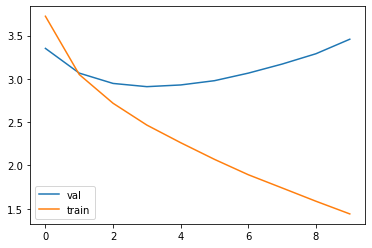

In [316]:
plt.plot(np.arange(len(val_losses_epoch)), val_losses_epoch, label = "val")
plt.plot(np.arange(len(losses_epoch)), losses_epoch, label = 'train')
plt.legend()